In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 186 kB 34.3 MB/s 
     |████████████████████████████████| 1.2 MB 30.5 MB/s 
     |████████████████████████████████| 56 kB 2.4 MB/s 
     |████████████████████████████████| 51 kB 211 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [3]:
Path.BASE_PATH = path

In [4]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

### Data Preprocessing
- Preprocess the dataset for the language model
- Manually tokenize and numericalize the data
- Create batches for the model to read

In [5]:
text = " . ".join(line.strip() for line in lines)
text[:50]

'one . two . three . four . five . six . seven . ei'

In [6]:
# get the tokens by splitting on spaces
tokens = text.split()
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [7]:
vocab = list(set(tokens))
vocab[:10]

['twenty',
 'three',
 '.',
 'fourteen',
 'seventeen',
 'fifty',
 'nine',
 'one',
 'thirty',
 'forty']

In [8]:
word2index = {word: i for i, word in enumerate(vocab)}
word2index['two']

21

In [9]:
num_tokens = [word2index[word] for word in tokens]
num_tokens[:10]

[7, 2, 21, 2, 1, 2, 28, 2, 19, 2]

In [10]:
len_tks = 6

for i in range(0,len_tks-4,3):
  print(i)

0


In [11]:
print(len(tokens))

63095


In [12]:
# want sequences of consecutive characters
seq_len = 16
seqs = [(torch.Tensor(num_tokens[i: i+seq_len]).long(), torch.Tensor(num_tokens[i+1:i+seq_len+1]).long()) for i in range(0,len(num_tokens)-seq_len-1, seq_len)]
seqs[:2]                                                                                         

[(tensor([ 7,  2, 21,  2,  1,  2, 28,  2, 19,  2, 14,  2, 16,  2, 18,  2]),
  tensor([ 2, 21,  2,  1,  2, 28,  2, 19,  2, 14,  2, 16,  2, 18,  2,  6])),
 (tensor([ 6,  2, 29,  2, 22,  2, 26,  2, 10,  2,  3,  2, 20,  2, 13,  2]),
  tensor([ 2, 29,  2, 22,  2, 26,  2, 10,  2,  3,  2, 20,  2, 13,  2,  4]))]

In [13]:
# want data in order
# (0, m, 2m, ..., )

def group_chunks(dset, bs):
  m = len(dset) // bs
  new_dset = []

  for i in range(m):
    new_dset += [dset[i + m*j] for j in range(bs)]
  return new_dset

In [14]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [15]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

### Experiment with RNNs
- Write RNNs from scratch

In [16]:
class LMModel1(Module):
  def __init__(self, vocab_sz, n_hidden):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.h_h = nn.Linear(n_hidden, n_hidden)
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.h = 0
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # print(x.shape)
    outs = []
    for i in range(x.shape[1]):
      # add the hidden state to the input to hidden state
      self.h = self.h + self.i_h(x[:, i])
      # compute new hidden state
      self.h = self.relu(self.h_h(self.h))
      # make a prediction for new character
      outs.append(self.h_o(self.h))

      
    self.h = self.h.detach()
    outs = torch.stack(outs, dim=1)
    # print(outs.shape)

    return outs
  
  
  def reset(self):
    self.h = 0

In [17]:
def flat_cross_entropy(inp, targ):
  # flatten the target from (bs, seq) -> (bs*seq)
  # accomodate by flattening inputs (bs, seq, vocab_sz) -> (bs*seq, vocab_sz)
  return F.cross_entropy(inp.view(bs*seq_len, -1), targ.view(-1))

In [18]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [19]:
print(len(vocab))

30


SuggestedLRs(valley=0.0010000000474974513)

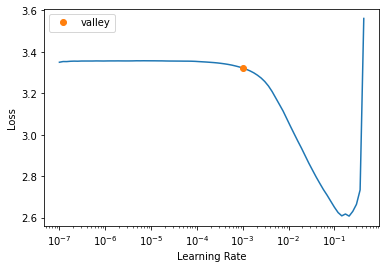

In [20]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=flat_cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn.lr_find()

In [21]:
learn.fit_one_cycle(20, 0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,3.323441,3.309674,0.036621,00:01
1,3.209437,3.100973,0.291016,00:01
2,2.792349,2.227321,0.416911,00:01
3,2.113846,1.895303,0.473551,00:01
4,1.754839,1.870028,0.474609,00:01
5,1.569274,1.816618,0.474691,00:01
6,1.452861,1.807349,0.468669,00:01
7,1.379259,1.766390,0.480876,00:01
8,1.328319,1.754932,0.499430,00:01
9,1.293603,1.732118,0.490641,00:01


### Multilayer RNN
- Experiment with multilayer RNNs
- Have a different hidden state in effect making the model deeper (more params to update)
- Make the multilayer RNN from scratch
- Make the multilayer RNN using pytorch

In [17]:
class LMModel2(Module):

  def __init__(self, vocab_sz, n_hidden, n_layers):
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.relu = nn.ReLU()
    # must create hidden state for each layer in the network
    self.h = torch.zeros(n_layers, bs, n_hidden)

    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.rnn_layers = []
    # create the middle rnn layers according to n_layers
    for i in range(n_layers):
      self.rnn_layers.append(nn.Linear(n_hidden, n_hidden))
    self.h_o = nn.Linear(n_hidden, vocab_sz)


  def forward(self, x):
    outs = []

    # loop through the sequence of inputs
    for i in range(x.shape[1]):
      # update the hidden state for the first RNN layer
      self.h.data[0] = self.h.data[0] + self.i_h(x[:, i])

      # loop through multilayers and apply them
      for i, h_layer in enumerate(self.rnn_layers):
        if i == 0:
          # already dealt with input to first layer above, apply hidden layer
          self.h.data[i] = self.relu(h_layer(self.h.data[i]))

        else:
          # pass prev activations in
          self.h.data[i] = self.h.data[i] + self.h.data[i-1]
          # apply new RNN layer
          self.h.data[i] = self.relu(h_layer(self.h.data[i]))
      
      # at the end, go hidden to output on the last set of activations
      outs.append(self.h_o(self.h[-1]))

    # detach the gradients
    self.h = self.h.detach()

    return torch.stack(outs, dim=1)
  
  def reset(self):
    # reset the hidden state on epoch or validation
    # self.h = torch.zeros(self.n_layers, bs, self.n_hidden)
    self.h = torch.zeros_like(self.h)

In [18]:
learn = Learner(dls, LMModel2(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.336657,3.264450,0.029053,00:01
1,3.054815,2.894682,0.124674,00:01
2,2.864093,2.818560,0.162109,00:01
3,2.783172,2.801814,0.174235,00:01
4,2.751319,2.798034,0.171387,00:01
5,2.740172,2.797850,0.148438,00:01
6,2.736782,2.797473,0.146322,00:01
7,2.735783,2.797346,0.146159,00:01


## Realizations from above
- After writing the RNN code, I realized that it was not training
- You cannot index into a variable in pytorch and set it partially when requires grad; a work around would be needed for this
- If the indexing in pytorch did not require a work around, the previous model would have worked
- Try implementing multilayer rnn with pytorch now

In [37]:
# override the previous LMModel2 class
class LMModel2(Module):
  def __init__(self, vocab_sz, n_hidden, n_layers):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.h = torch.zeros(n_layers, bs, n_hidden)

  
  def forward(self, x):
    inps = self.i_h(x)
    # this does all of the for loops and indexing to end with a final outs variable
    outs, hid = self.rnn(inps, self.h)
    # print(hid.grad)
    self.h = self.h.detach()
    return self.h_o(outs)
  

  def reset(self):
    self.h.zero_()

In [38]:
learn = Learner(dls, LMModel2(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.773918,2.088853,0.445394,00:01
1,1.890882,1.825922,0.440837,00:01
2,1.607420,1.900379,0.330892,00:01
3,1.471005,1.938458,0.343913,00:01
4,1.390500,1.917730,0.377279,00:01
5,1.337064,2.002375,0.373779,00:01
6,1.302500,2.039661,0.373779,00:01
7,1.283795,2.055036,0.374349,00:01


In [39]:
learn.model

LMModel2(
  (i_h): Embedding(30, 64)
  (rnn): RNN(64, 64, num_layers=2, batch_first=True)
  (h_o): Linear(in_features=64, out_features=30, bias=True)
)

In [46]:
learn.model.parameters()

<generator object Module.parameters at 0x7f50c55a9cd0>

In [48]:
# run one epochs and look at gradients
# for x, y in dls.train:
#   preds = learn.model(x)

#   loss = learn.loss(preds, y)
#   loss.backward()

#   print(learn.model.parameters().grad)


In [23]:
learn.model.h_o.weight

Parameter containing:
tensor([[-0.1346, -0.0105, -0.0292,  ...,  0.1076,  0.1697, -0.0790],
        [-0.1446, -0.1159, -0.0657,  ...,  0.3506,  0.0702, -0.1373],
        [-0.0230,  0.2399, -0.0219,  ..., -0.0172, -0.1246, -0.0223],
        ...,
        [ 0.0767, -0.2379,  0.1511,  ...,  0.1802, -0.0354, -0.0948],
        [ 0.0534, -0.1983,  0.1668,  ..., -0.0494, -0.1688, -0.1655],
        [-0.1557, -0.0960, -0.1385,  ..., -0.2076,  0.0217, -0.0095]], requires_grad=True)

### Implement LSTM 
- First implement it from scratch
- Then, implement from scratch with matrix mult and chunks in 4
- Finally implement using pytorch

In [16]:
class LSTMCell(Module):
  def __init__(self, x_sz, h_sz):
    # create 4 different gates, each for the type of gate in the lstm cell
    self.forget = nn.Linear(x_sz + h_sz, h_sz)
    self.input = nn.Linear(x_sz + h_sz, h_sz)
    self.cell = nn.Linear(x_sz + h_sz, h_sz)
    self.output = nn.Linear(x_sz + h_sz, h_sz)
  
    self.sig = nn.Sigmoid()
    self.tanh = nn.Tanh()
  

  def forward(self, x, state):
    # spread the hidden state
    h, c = state
    # concat the inputs
    all_inps = torch.cat([x, h], dim=1)

    c = c * self.sig(self.forget(all_inps))

    input_combined = self.sig(self.input(all_inps)) * self.tanh(self.cell(all_inps))
    c = c + input_combined

    h = self.sig(self.output(all_inps)) * self.tanh(c)

    return h, (h, c)



In [17]:
class LSTMCellSimplified(Module):
  def __init__(self, x_sz, h_sz):
    self.i_h = nn.Linear(x_sz, h_sz*4)
    self.h_h = nn.Linear(h_sz, h_sz*4)
    self.sig = nn.Sigmoid()
    self.tanh = nn.Tanh()
  
  def forward(self, x, state):
    h, c = state

    # combine the x input and hidden input into 4 gates
    all_gates = (self.i_h(x) + self.h_h(h)).chunk(4, dim=1)

    # apply functinos to layers
    forget, input, output = map(self.sig, all_gates[:3])
    cell = self.tanh(all_gates[3])

    # perform cell computations
    c = c * forget
    c = c + input*cell
    # note: you may need to flip this line to:
    # h = output * self.tanh(c)
    h = self.tanh(c) * output

    return h, (h, c)
